In [5]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Trainable Temperature 

In [34]:
torch.manual_seed(50)

n_classes = 20
dim = 3
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

rb = 0
bias_is_trainable = False
temperature_is_trainable = True
# Test a range of temperatures
t = 10  # 20 evenly spaced temperatures between 10 and 50
final_losses = []
final_temps = []
final_embeddings = []

print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

print(f"\nTesting temperature: {rb:.2f}")
experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str
)

U_final, V_final, criterion_final, losses_history = experiment.train(
    relative_bias=rb,
    temperature=t,
    trainable_temp=temperature_is_trainable,
    trainable_bias=bias_is_trainable
)

final_loss = losses_history[-1]
final_temp = criterion_final.get_temperature()

final_losses.append(final_loss)
final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar


print(f"Final Loss: {final_loss:.4f}")
print(f"Final Temperature: {final_temp:.4f}")

final_embeddings.append((U_final, V_final))
    #experiment.plot_inner_product_gap(U_final, V_final)
    #plt.savefig(f'logs/inner_product_gap_{rb:.2f}.png')

Using device: cpu
Running experiments with: n_classes=20, dim=3, n_epochs=10000

Testing temperature: 0.00
[100/10000]  loss=0.2621  T=6.0330  rb=0.0000
[200/10000]  loss=0.1418  T=6.3362  rb=0.0000
[300/10000]  loss=0.1314  T=6.8213  rb=0.0000
[400/10000]  loss=0.1260  T=7.4045  rb=0.0000
[500/10000]  loss=0.1218  T=8.0980  rb=0.0000
[600/10000]  loss=0.1180  T=8.9174  rb=0.0000
[700/10000]  loss=0.1141  T=9.8854  rb=0.0000
[800/10000]  loss=0.1102  T=11.0313  rb=0.0000
[900/10000]  loss=0.1062  T=12.3911  rb=0.0000
[1000/10000]  loss=0.1021  T=14.0118  rb=0.0000
[1100/10000]  loss=0.0978  T=15.9571  rb=0.0000
[1200/10000]  loss=0.0934  T=18.3088  rb=0.0000
[1300/10000]  loss=0.0889  T=21.1548  rb=0.0000
[1400/10000]  loss=0.0842  T=24.6101  rb=0.0000
[1500/10000]  loss=0.0791  T=28.9239  rb=0.0000
[1600/10000]  loss=0.0734  T=34.4976  rb=0.0000
[1700/10000]  loss=0.0672  T=41.7460  rb=0.0000
[1800/10000]  loss=0.0606  T=51.3606  rb=0.0000
[1900/10000]  loss=0.0526  T=64.5921  rb=0.00

In [35]:
Unp = U_final.cpu().detach().numpy()
Vnp = V_final.cpu().detach().numpy()
Z = Unp @ Vnp.T
minsame = np.min(np.diag(Z))
maxdifff = np.max(Z - np.eye(Z.shape[0])*3)
margin = (minsame - maxdifff)/2
print(rb, margin)

0 0.012379663530737162


<function matplotlib.pyplot.show(close=None, block=None)>

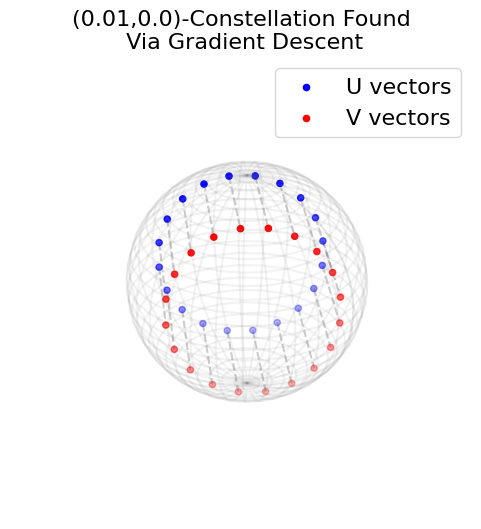

In [36]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax,
        title = f"({margin:.2f},{rb:.1f})-Constellation Found\n Via Gradient Descent"
    )
plt.savefig("logs/basicpicture.png",dpi=300, bbox_inches='tight')
plt.show

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


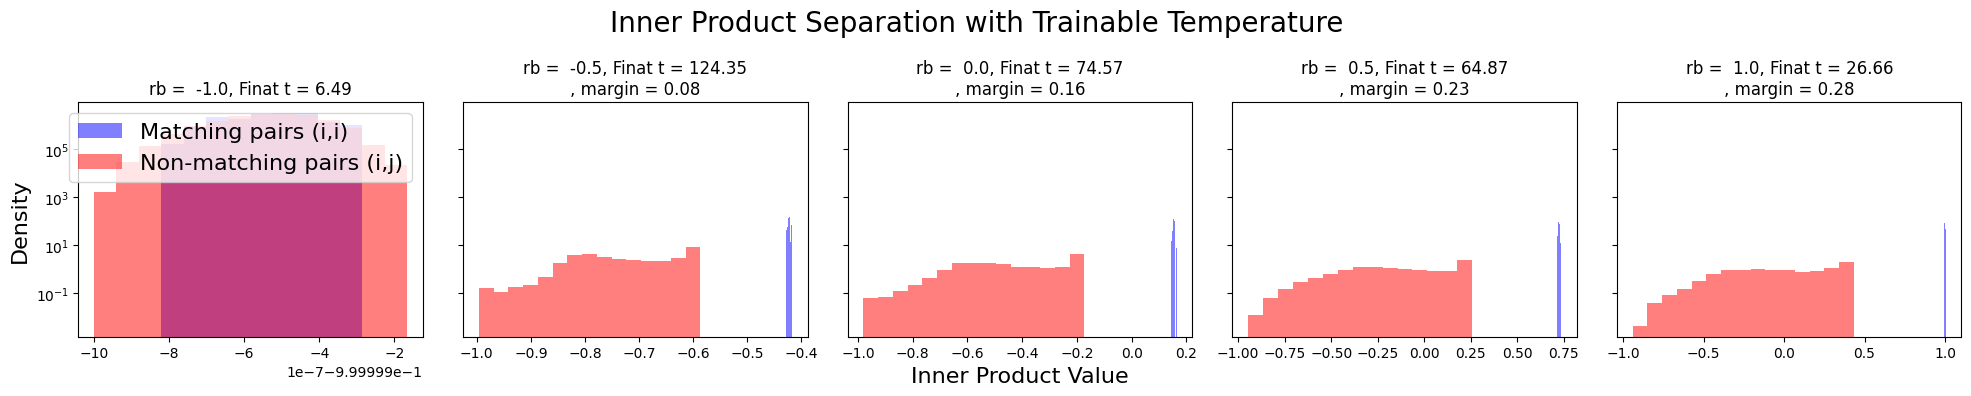

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

fig.suptitle('Inner Product Separation with Trainable Temperature', fontsize=20)
titles = [f"rb =  {rb:.1f}, Finat t = {final_temps[i]:.2f}" for i,rb in enumerate(initial_relative_biases)]
for i, ax in enumerate(axes):

    U_final, V_final = final_embeddings[i]
    inner_products = torch.matmul(U_final, V_final.t())
        # Get matching pairs (diagonal elements)
    matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
    if i>0:
        matching_pairs = matching_pairs + .002*np.random.normal(size = matching_pairs.shape)
        # Get non-matching pairs (off-diagonal elements)
    mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
    non_matching_pairs = inner_products[mask].detach().cpu().numpy()

    minsame= np.min(matching_pairs)
    maxdiff = np.max(non_matching_pairs)
    margin = (minsame - maxdiff)/2

        # Create histogram plot
    ax.hist(matching_pairs, bins= 15, alpha=0.5, label='Matching pairs (i,i)', color='blue', density=True, log = True)
    ax.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i,j)', color='red', density=True, log = True)

    if margin>0:
        titles[i]= titles[i] + f"\n, margin = {margin:.2f}"
    ax.set_title(titles[i])

    
    if i == 0:
        ax.set_ylabel('Density', fontsize = 16)
        ax.legend(fontsize= 16)
    if i == 2:
        ax.set_xlabel('Inner Product Value', fontsize = 16)
    
plt.tight_layout()
plt.savefig("logs/ablationtrainablelargetemperature.png",dpi=300, bbox_inches='tight')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

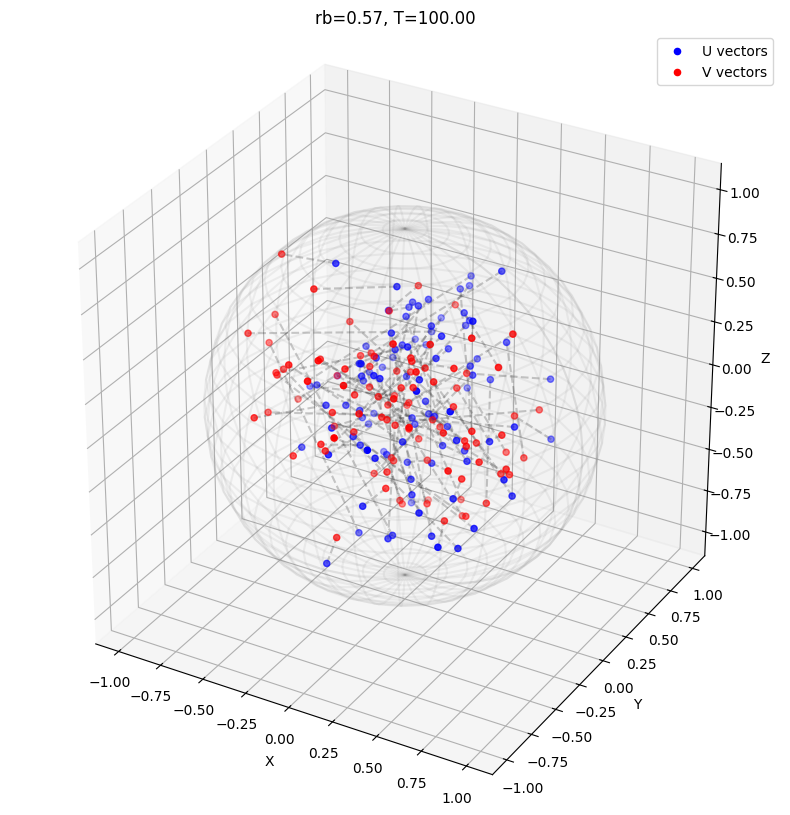

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show